In [ ]:
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, Dropout, BatchNormalization

In [ ]:
epochs = 30
timeStep = 32
# 6 features accl x,y,z + gyro x,y,z
featureCount = 6
# Ratio
sampleMultiplier = 4.5

In [ ]:
# 27 Out Of 29 Files are selected as the Training Data
trainingFiles = {'subject_001_01__x.csv': 'subject_001_01__y.csv',
                  'subject_001_02__x.csv': 'subject_001_02__y.csv',
                  'subject_001_03__x.csv': 'subject_001_03__y.csv',
                  'subject_001_04__x.csv': 'subject_001_04__y.csv',
                  'subject_001_05__x.csv': 'subject_001_05__y.csv',
                  'subject_001_06__x.csv': 'subject_001_06__y.csv',
                  'subject_001_07__x.csv': 'subject_001_07__y.csv',
                  'subject_001_08__x.csv': 'subject_001_08__y.csv',
                  'subject_002_01__x.csv': 'subject_002_01__y.csv',
                  'subject_002_02__x.csv': 'subject_002_02__y.csv',
                  'subject_002_03__x.csv': 'subject_002_03__y.csv',
                  'subject_002_04__x.csv': 'subject_002_04__y.csv',
                  'subject_002_05__x.csv': 'subject_002_05__y.csv',
                  'subject_003_01__x.csv': 'subject_003_01__y.csv',
                  'subject_003_02__x.csv': 'subject_003_02__y.csv',
                  'subject_003_03__x.csv': 'subject_003_03__y.csv',
                  'subject_004_01__x.csv': 'subject_004_01__y.csv',
                  'subject_004_02__x.csv': 'subject_004_02__y.csv',
                  'subject_005_01__x.csv': 'subject_005_01__y.csv',
                  'subject_005_02__x.csv': 'subject_005_02__y.csv',
                  'subject_005_03__x.csv': 'subject_005_03__y.csv',
                  'subject_006_03__x.csv': 'subject_006_03__y.csv',
                  'subject_008_01__x.csv': 'subject_008_01__y.csv',
                  'subject_007_03__x.csv': 'subject_007_03__y.csv',
                  'subject_007_04__x.csv': 'subject_007_04__y.csv'}

# 2 Out Of 29 Files are selected as the Validation Data
validationFiles = {'subject_006_01__x.csv': 'subject_006_01__y.csv','subject_006_02__x.csv': 'subject_006_02__y.csv'}

In [ ]:
# function to read input datafile - here the data is downsampled, interpolated and the results are compared before and after the preprocessing

def readFile(inputFile, outputFile, isValid):
  print("Processing: " + inputFile)
  data_x = pd.read_csv(inputFile, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
  # Mean Subtraction
  data_x = data_x - data_x.mean()
  # Interpolate missing values
  data_x = data_x.interpolate()
  data_x = data_x.values
  data_y = pd.read_csv(outputFile, names=['label']).values
  allCount = np.unique(data_y, returnCounts = True)
  minCount = min(allCount[1])
  acceptProb = [1,1,1,1]
  for i in range(len(allCount[0])):
    acceptProb[allCount[0][i]] = (minCount/allCount[1][i]) * sampleMultiplier
  if isValid:
    acceptProb = [1,1,1,1]
  print(acceptProb)
  lstmXinput = []
  for i in range(int(timeStep/4), data_y.shape[0]):
    sample = []
    for j in range((i*4)-(timeStep), (i*4)):
      sample.append(data_x[j])
    lstmXinput.append(sample)
  lstmXinput = np.asarray(lstmXinput)
  data_y = data_y[0: data_y.shape[0] - int(timeStep/4)]

  print("Before down-sampling")
  print("lstmXinput: " + str(lstmXinput.shape))
  print("data_y: " + str(data_y.shape))
  print("label dist.: " + str(np.unique(data_y, returnCounts = True)))
  
  lstm_select_data_x = []
  select_data_y = []
  for i in range(0, data_y.shape[0]):
    val = random.random()
    if val <= acceptProb[data_y[i][0]]:
      lstm_select_data_x.append(lstmXinput[i])
      select_data_y.append(data_y[i])
  lstm_select_data_x = np.asarray(lstm_select_data_x)
  select_data_y = np.asarray(select_data_y)

  print("After down-sampling")
  print("lstm_x_select_data: " + str(lstm_select_data_x.shape))
  print("y_select_data: " + str(select_data_y.shape))
  print("label distribution: " + str(np.unique(select_data_y, returnCounts = True)))

  return (lstm_select_data_x, np.squeeze(select_data_y))

In [ ]:
# function to read training data
def readTraining(): 
    input_x = np.empty((0, timeStep, featureCount))
    input_y = np.empty((0,))
    for inputFile, outputFile in trainingFiles.items():
        temp_x, temp_y = readFile(inputFile, outputFile, False)
        input_x = np.append(input_x, temp_x, axis=0)
        input_y = np.append(input_y, temp_y, axis=0)
    print('Training X: ' + str(input_x.shape))
    print('Training Y: ' + str(input_y.shape))
    print("label distribution: " + str(np.unique(input_y, returnCounts = True)))
    return (input_x, input_y)

In [ ]:
(Xtrain, Ytrain) = readTraining()

Processing: subject_001_01__x.csv
[0.4965083798882681, 4.5, 4.060279187817259, 2.0911764705882354]
Before down-sampling
lstm_x_input: (9465, 32, 6)
y_data: (9465, 1)
label dist.: (array([0, 1, 2, 3]), array([6436,  711,  788, 1530]))
After down-sampling
lstm_x_select_data: (6236, 32, 6)
y_select_data: (6236, 1)
label dist.: (array([0, 1, 2, 3]), array([3207,  711,  788, 1530]))
Processing: subject_001_02__x.csv
[0.34987267229030716, 4.5, 3.829703832752613, 1.5415497896213184]
Before down-sampling
lstm_x_input: (17535, 32, 6)
y_data: (17535, 1)
label dist.: (array([0, 1, 2, 3]), array([12558,   977,  1148,  2852]))
After down-sampling
lstm_x_select_data: (9435, 32, 6)
y_select_data: (9435, 1)
label dist.: (array([0, 1, 2, 3]), array([4458,  977, 1148, 2852]))
Processing: subject_001_03__x.csv
[0.3649234847571997, 4.5, 2.738245931283906, 4.271509167842031]
Before down-sampling
lstm_x_input: (10779, 32, 6)
y_data: (10779, 1)
label dist.: (array([0, 1, 2, 3]), array([8291,  673, 1106,  709

In [ ]:
YtrainCat = []
for y in Ytrain:
    if y == 0:
        YtrainCat.append([1,0,0,0])
    elif y == 1:
        YtrainCat.append([0,1,0,0])
    elif y == 2:
        YtrainCat.append([0,0,1,0])
    else:
        YtrainCat.append([0,0,0,1])
Ytrain = np.asarray(YtrainCat)
print(Ytrain.shape)

(109986, 4)


In [ ]:
# function to read validation data
def readValidation(): 
    input_x = np.empty((0, timeStep, featureCount))
    input_y = np.empty((0,))
    for inputFile, outputFile in validationFiles.items():
        temp_x, temp_y = readFile(inputFile, outputFile, True)
        input_x = np.append(input_x, temp_x, axis=0)
        input_y = np.append(input_y, temp_y, axis=0)
    print('Validation X: ' + str(input_x.shape))
    print('Validation Y: ' + str(input_y.shape))
    print("label dist.: " + str(np.unique(input_y, returnCounts = True)))
    return (input_x, input_y)

In [ ]:
(Xval, Yval) = readValidation()

Processing: subject_006_01__x.csv
[1, 1, 1, 1]
Before down-sampling
lstm_x_input: (12023, 32, 6)
y_data: (12023, 1)
label dist.: (array([0, 1, 2, 3]), array([9502,  575,  826, 1120]))
After down-sampling
lstm_x_select_data: (12023, 32, 6)
y_select_data: (12023, 1)
label dist.: (array([0, 1, 2, 3]), array([9502,  575,  826, 1120]))
Processing: subject_006_02__x.csv
[1, 1, 1, 1]
Before down-sampling
lstm_x_input: (14883, 32, 6)
y_data: (14883, 1)
label dist.: (array([0, 1, 2, 3]), array([12269,   544,   482,  1588]))
After down-sampling
lstm_x_select_data: (14883, 32, 6)
y_select_data: (14883, 1)
label dist.: (array([0, 1, 2, 3]), array([12269,   544,   482,  1588]))
Validation X: (26906, 32, 6)
Validation Y: (26906,)
label dist.: (array([0., 1., 2., 3.]), array([21771,  1119,  1308,  2708]))


In [ ]:
YvalCat = []
for y in Yval:
    if y == 0:
        YvalCat.append([1,0,0,0])
    elif y == 1:
        YvalCat.append([0,1,0,0])
    elif y == 2:
        YvalCat.append([0,0,1,0])
    else:
        YvalCat.append([0,0,0,1])
Yval = np.asarray(YvalCat)
print(Yval.shape)

(26906, 4)


In [ ]:
from keras import backend as K
import tensorflow as tf

In [ ]:
# defining functions to calculate performance metrices
def recall(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    allPositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    recall = truePositives / (allPositives + K.epsilon())
    return recall

def precision(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPred, 0, 1)))
    precision = truePositives / (predictedPositives + K.epsilon())
    return precision

def f1_score(yTrue, yPred):
    precision = precision(yTrue, yPred)
    recall = recall(yTrue, yPred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# defining LSTM model architecture: we added an extra Bi-LSTM layer and reduced dropout values from our base literature to improve performance
model = Sequential()
model.add(LSTM(units = 100, input_shape=(timeStep, featureCount), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units = 100, return_sequences=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['categorical_accuracy', f1_score, precision, recall])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32, 100)           42800     
                                                                 
 dropout_2 (Dropout)         (None, 32, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 100)           80400     
                                                                 
 dropout_3 (Dropout)         (None, 32, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                      

In [ ]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(109986, 32, 6)
(109986, 4)
(26906, 32, 6)
(26906, 4)


In [ ]:
history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=32, shuffle=False, validation_data=(Xval, Yval))

Epoch 1/30
3438/3438 [==============================] - 45s 13ms/step - loss: 0.6519 - categorical_accuracy: 0.7126 - f1_m: 0.6853 - precision_m: 0.7162 - recall_m: 0.6664 - val_loss: 0.4708 - val_categorical_accuracy: 0.8702 - val_f1_m: 0.8679 - val_precision_m: 0.8729 - val_recall_m: 0.8636
Epoch 2/30
3438/3438 [==============================] - 44s 13ms/step - loss: 0.5203 - categorical_accuracy: 0.7824 - f1_m: 0.7719 - precision_m: 0.7877 - recall_m: 0.7616 - val_loss: 0.2596 - val_categorical_accuracy: 0.9148 - val_f1_m: 0.9133 - val_precision_m: 0.9172 - val_recall_m: 0.9098
Epoch 3/30
3438/3438 [==============================] - 41s 12ms/step - loss: 0.4446 - categorical_accuracy: 0.8233 - f1_m: 0.8168 - precision_m: 0.8280 - recall_m: 0.8097 - val_loss: 0.2121 - val_categorical_accuracy: 0.9324 - val_f1_m: 0.9319 - val_precision_m: 0.9349 - val_recall_m: 0.9291
Epoch 4/30
3438/3438 [==============================] - 42s 12ms/step - loss: 0.3932 - categorical_accuracy: 0.8481 - 

In [ ]:
def plotHistory(history):
    # plot loss
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.legend(['Train', 'Validation'])
    plt.show()

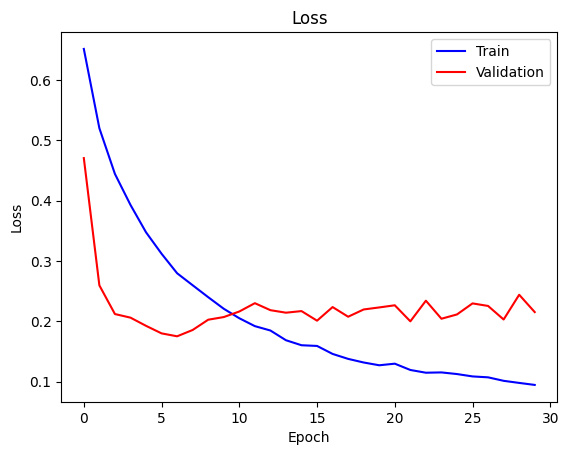

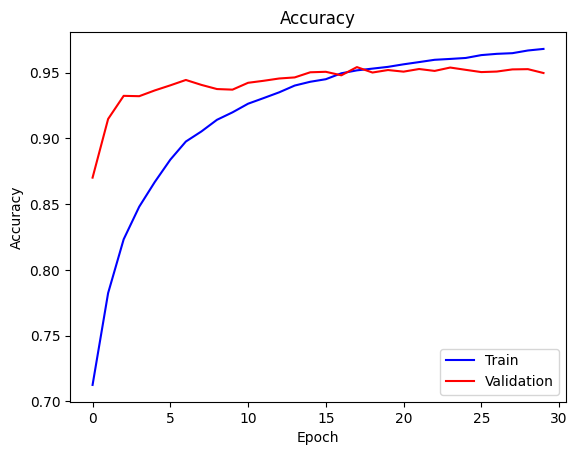

In [ ]:
plotHistory(history)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

In [ ]:
# testing metrices on one pair of test-data and predictions
testingFileInfo = {'subject_007_01__x.csv': 'subject_007_01__y.csv',
                        'subject_007_02__x.csv': 'subject_007_02__y.csv'}

outputFileInfo = {'subject_007_01__x.csv': 'subject_007_01__y_prediction.csv',
                        'subject_007_02__x.csv': 'subject_007_02__y_prediction.csv'}

for inputFile, inputFileTime_y in testingFileInfo.items():
  print(inputFile)
  testDataX = pd.read_csv(inputFile, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
  # Mean Subtraction
  testDataX = testDataX - testDataX.mean()
  testDataX = testDataX.values
  trueLabel_y = pd.read_csv(inputFileTime_y, names=['label'])
  print(trueLabel_y.shape)
  lstmXinput = []
  for i in range(int(timeStep/4), trueLabel_y.shape[0]):
    sample = []
    for j in range((i*4)-(timeStep), (i*4)):
      sample.append(testDataX[j])
    lstmXinput.append(sample)
  testDataX = np.asarray(lstmXinput)
  print(testDataX.shape)
  testPredY = model.predict(testDataX)
  result = []
  for i in range(0, len(testPredY)):
    result.append(np.argmax(testPredY[i]))
  np.asarray(result)
  print("True: " + str(np.unique(trueLabel_y, returnCounts = True)))
  print("Predict: " + str(np.unique(result, returnCounts = True)))
  outfile = open(outputFileInfo.get(inputFile),'w')
  out = csv.writer(outfile)
  out.writerows(map(lambda x: [x], result))
  outfile.close()  
  
  for i in range(int(timeStep/4)):
    result.insert(0,0)
  testY = np.array(trueLabel_y)
  # precision tp / (tp + fp)
  precision = precision_score(testY, result, average='macro')
  # recall: tp / (tp + fn)
  recall = recall_score(testY, result, average='macro')
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(testY, result, average='macro')
  print('Precision: %f; Recall: %f; F1 score: %f' % (precision, recall, f1))
  matrix = confusion_matrix(result, testY)
  print(matrix)

  # f1_score(pred[subjID],gt[subjID],average='macro')

subject_007_01__x.csv
(11550, 1)
(11542, 32, 6)
361/361 [==============================] - 2s 5ms/step
True: (array([0, 1, 2, 3]), array([7916,  382,  540, 2712]))
Predict: (array([0, 1, 2, 3]), array([8616,  414,  548, 1964]))
Precision: 0.868272; Recall: 0.849089; F1 score: 0.853114
[[7555   30   46  993]
 [  53  350    0   11]
 [  57    0  485    6]
 [ 251    2    9 1702]]
subject_007_02__x.csv
(11747, 1)
(11739, 32, 6)
367/367 [==============================] - 2s 5ms/step
True: (array([0, 1, 2, 3]), array([8446,  121,  542, 2638]))
Predict: (array([0, 1, 2, 3]), array([8572,  128,  577, 2462]))
Precision: 0.861967; Recall: 0.877797; F1 score: 0.869242
[[7940   15   35  590]
 [  18  106    0    4]
 [  71    0  500    6]
 [ 417    0    7 2038]]


In [ ]:
# testing predictions on the target subject files
testingFileInfo = {'subject_009_01__x.csv': 'subject_009_01__y_time.csv',
                    'subject_010_01__x.csv': 'subject_010_01__y_time.csv',
                    'subject_011_01__x.csv': 'subject_011_01__y_time.csv',
                    'subject_012_01__x.csv': 'subject_012_01__y_time.csv'}

outputFileInfo = {'subject_009_01__x.csv': 'subject_009_01__y_prediction.csv',
                  'subject_010_01__x.csv': 'subject_010_01__y_prediction.csv',
                  'subject_011_01__x.csv': 'subject_011_01__y_prediction.csv',
                  'subject_012_01__x.csv': 'subject_012_01__y_prediction.csv'}

for inputFile, inputFileTime_y in testingFileInfo.items():
        print(inputFile)
        testDataX = pd.read_csv(inputFile, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
        # Mean Subtraction
        testDataX = testDataX - testDataX.mean()
        testDataX = testDataX.values
        testTimeY = pd.read_csv(inputFileTime_y, names=['label'])
        print(testTimeY.shape)
        lstmXinput = []
        for i in range(int(timeStep/4), testTimeY.shape[0]):
          sample = []
          for j in range((i*4)-(timeStep), (i*4)):
            sample.append(testDataX[j])
          lstmXinput.append(sample)
        testDataX = np.asarray(lstmXinput)
        print(testDataX.shape)
        testPredY = model.predict(testDataX)
        result = []
        for i in range(0, len(testPredY)):
          result.append(np.argmax(testPredY[i]))
        np.asarray(result)
        print(np.unique(result, returnCounts = True))
        outfile = open(outputFileInfo.get(inputFile),'w')
        out = csv.writer(outfile)
        out.writerows(map(lambda x: [x], result))
        outfile.close()

subject_009_01__x.csv
(9498, 1)
(9490, 32, 6)
297/297 [==============================] - 2s 8ms/step
(array([0, 1, 2, 3]), array([7687,  389,  178, 1236]))
subject_010_01__x.csv
(12270, 1)
(12262, 32, 6)
384/384 [==============================] - 2s 5ms/step
(array([0, 1, 2, 3]), array([6987,  439,  481, 4355]))
subject_011_01__x.csv
(12940, 1)
(12932, 32, 6)
405/405 [==============================] - 2s 6ms/step
(array([0, 1, 2, 3]), array([9136,  509,  758, 2529]))
subject_012_01__x.csv
(11330, 1)
(11322, 32, 6)
354/354 [==============================] - 2s 4ms/step
(array([0, 1, 2, 3]), array([8248,  646,  869, 1559]))


In [ ]:
# References: 
# https://github.com/mitanachien/Terrain-Identification-for-Time-Series-Data,
# Dixon, Philippe Schutte, K.H. Vanwanseele, Benedicte Jacobs, ¨Jesse Dennerlein, Jack Schiffman, Jeffrey Fournier, P-A Hu,Boyi. (2019). Machine learning algorithms can classify outdoor terrain types during running using accelerometry data. Gait Posture. 74.10.1016/j.gaitpost.2019.09.005. ,
# Nampoothiri, M.G.H., Anand, P.S.G. Antony, R. Real time terrain identification of autonomous robots using machine learning. Int J Intell RobotAppl 4, 265–277 (2020). https://doi.org/10.1007/s41315-020-00142-3